In [39]:
import numpy as np
import torch
import torchvision.transforms as T
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
from torchvision import models
import torch.hub
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

### Volume Estimation

In [40]:
# Load MiDaS model for depth estimation
model_type = "DPT_Large"  # Options: "DPT_Large", "DPT_Hybrid", "MiDaS_small"
midas = torch.hub.load("intel-isl/MiDaS", model_type)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

# Load MiDaS transforms
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform_midas = midas_transforms.dpt_transform if model_type in ["DPT_Large", "DPT_Hybrid"] else midas_transforms.small_transform

# Load Mask R-CNN for segmentation
maskrcnn_model = maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT)
maskrcnn_model.to(device)
maskrcnn_model.eval()

# Function for loading and preprocessing the image
def load_and_preprocess_image(image_path):
    # Load and transform image for depth estimation
    img = cv2.imread(image_path)
    print("Original RGB Pixel Array of Input Image:")
    print(img)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print("Image converted to RGB Pixel Array:")
    print(img_rgb)
    input_batch = transform_midas(img_rgb).to(device)
    return img, img_rgb, input_batch

    
    
# Function for depth estimation
def estimate_depth(input_batch):
    with torch.no_grad():
        prediction = midas(input_batch)
        depth = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=input_batch.shape[2:],
            mode="bicubic",
            align_corners=False,
        ).squeeze()
    depth_map = depth.cpu().numpy()
    print("Depth Map:")
    print(depth_map)
    return depth_map
    

# Function for segmentation with Mask R-CNN
def segment_objects(image_rgb):
    transform = T.ToTensor()
    img_tensor = transform(image_rgb).to(device)
    with torch.no_grad():
        predictions = maskrcnn_model([img_tensor])
    return predictions[0]

def calculate_volume(depth_map, masks, pixel_to_cm, depth_scale, threshold=0.5):
    """
    Calculate the volume of objects using depth map and masks.
    :param depth_map: Depth map (NumPy array).
    :param masks: List of binary masks (NumPy arrays).
    :param pixel_to_cm: Pixel to cm conversion factor.
    :param depth_scale: Depth scale factor.
    :param threshold: Threshold for binary mask conversion.
    :return: List of calculated volumes in cm³.
    """
    volumes = []
    for i, mask in enumerate(masks):
        # Resize depth map to the mask's size
        depth_map_resized = cv2.resize(depth_map, (mask.shape[1], mask.shape[0]))
        print(f"Scaled Depth Map for Object {i + 1}:")
        print(depth_map_resized)

        # Threshold the mask (if needed)
        mask_binary = (mask > threshold).astype(np.uint8)

        # Apply mask to depth map
        depth_masked = depth_map_resized * mask_binary
        print(f"Masked Depth Map for Object {i + 1}:")
        print(depth_masked)

        # Calculate area in pixels and convert to cm²
        area_pixels = np.sum(mask_binary)
        area_cm2 = area_pixels * (pixel_to_cm ** 2)
        print(f"Object {i + 1} - Area in Pixels: {area_pixels}")
        print(f"Object {i + 1} - Area in cm²: {area_cm2:.2f}")

        # Calculate mean depth (height in cm)
        depth_values = depth_masked[mask_binary > 0]
        height_cm = np.mean(depth_values) * depth_scale if depth_values.size > 0 else 0
        print(f"Object {i + 1} - Height in cm: {height_cm:.2f}")

        # Calculate volume
        volume = area_cm2 * height_cm
        volumes.append(volume)

    return volumes

Using cache found in C:\Users\User/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\User/.cache\torch\hub\intel-isl_MiDaS_master


Inputs -> Confidence: 0.9850282669067383, Threshold: 0.1, Compactness: 0.852203538089989
Output -> Mask Quality: 0.8220932831851169
Inputs -> Confidence: 0.9850282669067383, Threshold: 0.2, Compactness: 0.8655356818468791
Output -> Mask Quality: 0.8238341635407672
Inputs -> Confidence: 0.9850282669067383, Threshold: 0.30000000000000004, Compactness: 0.8763234741224263
Output -> Mask Quality: 0.8251582177520506
Inputs -> Confidence: 0.9850282669067383, Threshold: 0.4, Compactness: 0.8825814942393012
Output -> Mask Quality: 0.8258899188765064
Inputs -> Confidence: 0.9850282669067383, Threshold: 0.5, Compactness: 0.8847052277717182
Output -> Mask Quality: 0.8261319695300778
Inputs -> Confidence: 0.9850282669067383, Threshold: 0.6, Compactness: 0.8822380478652084
Output -> Mask Quality: 0.825850473998561
Inputs -> Confidence: 0.9850282669067383, Threshold: 0.7000000000000001, Compactness: 0.875292001066164
Output -> Mask Quality: 0.8250350110106782
Inputs -> Confidence: 0.9850282669067383,

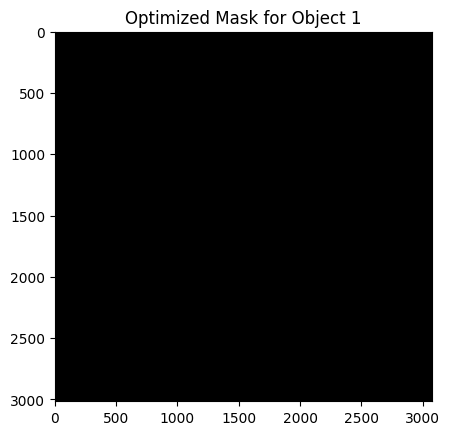

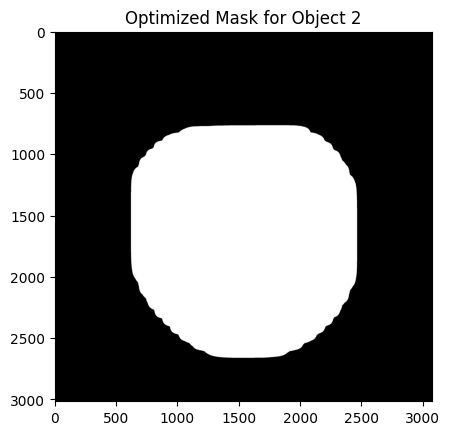

Scaled Depth Map for Object 1:
[[ 0.5570541   0.5570541   0.5570541  ...  0.93971634  0.93971634
   0.93971634]
 [ 0.5570541   0.5570541   0.5570541  ...  0.93971634  0.93971634
   0.93971634]
 [ 0.5570541   0.5570541   0.5570541  ...  0.93971634  0.93971634
   0.93971634]
 ...
 [15.431556   15.431556   15.431556   ... 17.892586   17.892586
  17.892586  ]
 [15.431556   15.431556   15.431556   ... 17.892586   17.892586
  17.892586  ]
 [15.431556   15.431556   15.431556   ... 17.892586   17.892586
  17.892586  ]]
Masked Depth Map for Object 1:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Object 1 - Area in Pixels: 0
Object 1 - Area in cm²: 0.00
Object 1 - Height in cm: 0.00
Scaled Depth Map for Object 2:
[[ 0.5570541   0.5570541   0.5570541  ...  0.93971634  0.93971634
   0.93971634]
 [ 0.5570541   0.5570541   0.5570541  ...  0.93971634  0.93971634
   0.93971634]
 [ 0.5570541   

In [41]:
import numpy as np
import numpy as np
import skfuzzy as fuzz
import skfuzzy.control as ctrl
import cv2
import torchvision.transforms as T
from matplotlib import pyplot as plt

# Define fuzzy variables
confidence = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'confidence')
threshold = ctrl.Antecedent(np.arange(0.1, 1.1, 0.1), 'threshold')
compactness = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'compactness')
mask_quality = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'mask_quality')

# Membership functions for confidence
confidence['low'] = fuzz.trimf(confidence.universe, [0, 0, 0.5])
confidence['medium'] = fuzz.trimf(confidence.universe, [0.3, 0.5, 0.7])
confidence['high'] = fuzz.trimf(confidence.universe, [0.5, 1, 1])

# Membership functions for threshold
threshold['low'] = fuzz.trimf(threshold.universe, [0.1, 0.1, 0.5])
threshold['medium'] = fuzz.trimf(threshold.universe, [0.3, 0.5, 0.7])
threshold['high'] = fuzz.trimf(threshold.universe, [0.5, 1, 1])

# Membership functions for compactness
compactness['low'] = fuzz.trimf(compactness.universe, [0, 0, 0.5])
compactness['medium'] = fuzz.trimf(compactness.universe, [0.3, 0.5, 0.7])
compactness['high'] = fuzz.trimf(compactness.universe, [0.5, 1, 1])

# Membership functions for mask quality
mask_quality['poor'] = fuzz.trimf(mask_quality.universe, [0, 0, 0.5])
mask_quality['average'] = fuzz.trimf(mask_quality.universe, [0.3, 0.5, 0.7])
mask_quality['good'] = fuzz.trimf(mask_quality.universe, [0.5, 1, 1])

# Define fuzzy rules
rule1 = ctrl.Rule(confidence['high'] & compactness['high'], mask_quality['good'])
rule2 = ctrl.Rule(confidence['medium'] & threshold['low'], mask_quality['average'])
rule3 = ctrl.Rule(confidence['low'] & compactness['low'], mask_quality['poor'])
rule4 = ctrl.Rule(threshold['medium'] & compactness['medium'], mask_quality['average'])
rule5 = ctrl.Rule(confidence['high'] & threshold['high'], mask_quality['good'])
rule6 = ctrl.Rule(confidence['low'] & compactness['high'], mask_quality['average'])
rule7 = ctrl.Rule(confidence['medium'] & compactness['low'], mask_quality['poor'])
rule8 = ctrl.Rule(confidence['low'] & threshold['high'], mask_quality['poor'])

# Create fuzzy control system
mask_quality_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8])
mask_quality_sim = ctrl.ControlSystemSimulation(mask_quality_ctrl)

# Function to apply fuzzy logic for mask quality evaluation
def evaluate_masks_with_fuzzy(predictions, depth_map):
    optimized_masks = []
    transform = T.ToTensor()
    scores = predictions['scores'].cpu().numpy()
    raw_masks = predictions['masks'].cpu().numpy()  # Raw masks from the model

    for i, mask in enumerate(raw_masks):
        # For each mask, evaluate using fuzzy logic
        confidence_score = scores[i]
        best_mask = None
        best_quality = -np.inf

        for threshold_value in np.linspace(0.1, 1.0, num=10):
            # Threshold the mask
            mask_binary = (mask[0] > threshold_value).astype(np.uint8)
            
            # Evaluate compactness (ratio of area to perimeter)
            contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if len(contours) > 0:
                area = cv2.contourArea(contours[0])
                perimeter = cv2.arcLength(contours[0], True)
                compactness_value = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
            else:
                compactness_value = 0

            # Use fuzzy logic to compute quality
            try:
                # Clamp input values to ensure they are in the valid range
                confidence_score = max(0, min(1, confidence_score))
                threshold_value = max(0.1, min(1, threshold_value))
                compactness_value = max(0, min(1, compactness_value))

                # Set inputs
                mask_quality_sim.input['confidence'] = confidence_score
                mask_quality_sim.input['threshold'] = threshold_value
                mask_quality_sim.input['compactness'] = compactness_value

                # Compute fuzzy output
                mask_quality_sim.compute()
                quality = mask_quality_sim.output['mask_quality']

                print(f"Inputs -> Confidence: {confidence_score}, Threshold: {threshold_value}, Compactness: {compactness_value}")
                print(f"Output -> Mask Quality: {quality}")

            except KeyError as e:
                print(f"KeyError: {e}")
                print(f"Inputs were Confidence: {confidence_score}, Threshold: {threshold_value}, Compactness: {compactness_value}")
                quality = 0  # Default to 0 quality if error occurs

            # Keep track of the best mask
            if quality > best_quality:
                best_quality = quality
                best_mask = mask_binary

        # Add the best mask for this object
        kernel = np.ones((3, 3), np.uint8)
        best_mask = cv2.morphologyEx(best_mask, cv2.MORPH_CLOSE, kernel)  # Close gaps
        optimized_masks.append(best_mask)

    return optimized_masks

# Example usage:
image_rgb = img_rgb.copy()
transform = T.ToTensor()
img_tensor = transform(image_rgb).to(device)
with torch.no_grad():
    predictions = maskrcnn_model([img_tensor])[0]

optimized_masks = evaluate_masks_with_fuzzy(predictions, depth_map)

# Visualize optimized masks (optional)
for i, mask in enumerate(optimized_masks):
    plt.imshow(mask, cmap="gray")
    plt.title(f"Optimized Mask for Object {i+1}")
    plt.show()

# Calculate volume using optimized masks
volumes_cm3 = calculate_volume(depth_map, optimized_masks, pixel_to_cm=0.001, depth_scale=depth_scale)

# Print estimated volumes
for i, volume in enumerate(volumes_cm3):
    print(f"Estimated Volume for Object {i+1}: {volume:.2f} cm³")

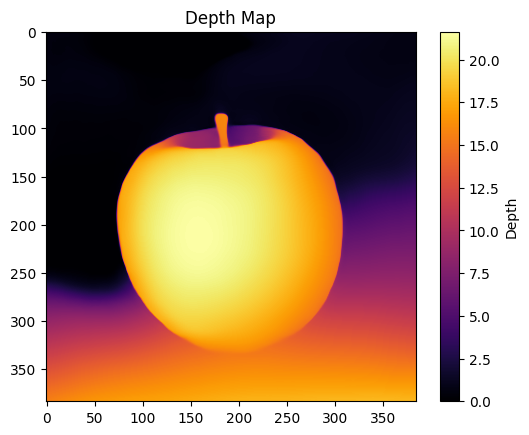

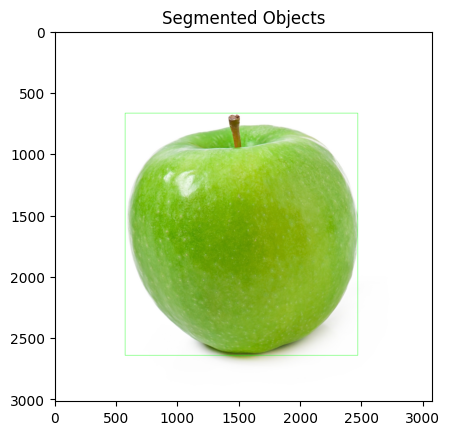

In [42]:
# Segment objects dynamically and keep raw predictions for visualization
img_tensor = T.ToTensor()(img_rgb).to(device)
with torch.no_grad():
    raw_predictions = maskrcnn_model([img_tensor])

# Visualize depth map
plt.imshow(depth_map, cmap="inferno")
plt.colorbar(label="Depth")
plt.title("Depth Map")
plt.show()

# Visualize segmented objects (using raw predictions)
img_segmented = img_rgb.copy()
for i, box in enumerate(raw_predictions[0]['boxes']):
    if raw_predictions[0]['scores'][i] > 0.5:  # Filter by confidence threshold
        x1, y1, x2, y2 = box.int().cpu().numpy()
        cv2.rectangle(img_segmented, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.imshow(img_segmented)
plt.title("Segmented Objects")
plt.show()


### Image Recognition and weight calculation

In [43]:
#"C:\123\SRMAP\Semester 7\DIP Lab Project\Image Classification\Fruits_Vegetables"
data_train_path = "C:/123/SRMAP/Semester 7/Image Classification/Fruits_Vegetables/train"
data_test_path = "C:/123/SRMAP/Semester 7/Image Classification/Fruits_Vegetables/test"
data_val_path = "C:/123/SRMAP/Semester 7/Image Classification/Fruits_Vegetables/validation"

In [44]:
img_width = 180
img_height =180

In [45]:
data_train = tf.keras.utils.image_dataset_from_directory(
    data_train_path,
    shuffle=True,
    image_size=(img_width, img_height),
    batch_size=32,
    validation_split=False)

Found 3115 files belonging to 36 classes.


In [46]:
data_cat = data_train.class_names

In [47]:
# Load the model
model = tf.keras.models.load_model("C:/123/SRMAP/Semester 7/Image Classification/Image_classify.keras")

# Verify the model structure
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [48]:
from tensorflow.keras.utils import load_img, img_to_array

In [49]:
#"C:\123\SRMAP\Semester 7\DIP Lab Project\Images to test on my own\"
#image = "C:/123/SRMAP/Semester 7/DIP Lab Project/Images to test on my own/apple-256268_1280.jpg"
image = image_path
image = load_img(image, target_size=(img_height,img_width))
img_arr = img_to_array(image)
img_bat = tf.expand_dims(img_arr, 0)

In [50]:
predict = model.predict(img_bat)

1/1 [==============================] - 0s 458ms/step


In [51]:
score = tf.nn.softmax(predict)

In [52]:
print('Veg/Fruit in image is {} with accuracy of {:0.2f}'.format(data_cat[np.argmax(score)],np.max(score)*100))

Veg/Fruit in image is apple with accuracy of 35.95


### Weight Calculation

In [53]:
# Define density values for the recognized classes (in g/cm³)
# Note: These values are approximate. Adjust based on more precise references if available.
densities = {
    'apple': 0.8,
    'banana': 0.94,
    'beetroot': 0.67,
    'bell pepper': 0.3,
    'cabbage': 0.45,
    'capsicum': 0.3,
    'carrot': 0.65,
    'cauliflower': 0.4,
    'chilli pepper': 0.2,
    'corn': 0.8,
    'cucumber': 0.65,
    'eggplant': 0.4,
    'garlic': 0.59,
    'ginger': 0.75,
    'grapes': 0.95,
    'jalepeno': 0.4,
    'kiwi': 0.88,
    'lemon': 0.92,
    'lettuce': 0.2,
    'mango': 1.0,
    'onion': 0.6,
    'orange': 0.95,
    'paprika': 0.3,
    'pear': 0.59,
    'peas': 0.72,
    'pineapple': 0.98,
    'pomegranate': 1.1,
    'potato': 0.71,
    'raddish': 0.61,
    'soy beans': 0.75,
    'spinach': 0.1,
    'sweetcorn': 0.8,
    'sweetpotato': 0.61,
    'tomato': 0.95,
    'turnip': 0.68,
    'watermelon': 0.95
}

In [54]:
# Function to calculate weight
def calculate_weight(volume_cm3, predicted_class):
    density = densities.get(predicted_class, None)  # Get density for the class
    if density is None:
        print(f"Density for {predicted_class} not found.")
        return None
    weight_g = volume_cm3 * density
    return weight_g

# Identify the fruit/vegetable class from the classifier
predicted_class = data_cat[np.argmax(score)]
print(f"Identified Object: {predicted_class}")

# Calculate weight for each detected object
weights = []
for i, volume_cm3 in enumerate(volumes_cm3):
    weight = calculate_weight(volume_cm3, predicted_class)
    if weight is not None:
        print(f"Object {i+1}: {predicted_class}, Volume: {volume_cm3:.2f} cm³, Weight: {weight:.2f} g")
        weights.append(weight)
    else:
        print(f"Object {i+1}: Volume: {volume_cm3:.2f} cm³. Unable to calculate weight.")

Identified Object: apple
Object 1: apple, Volume: 0.00 cm³, Weight: 0.00 g
Object 2: apple, Volume: 113.31 cm³, Weight: 90.65 g
